In [3]:
import numpy as np
import gzip
import pickle
from scipy.stats import rankdata
import collections
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Classificateur de type k-NN et représentants moyens

L'objectif de ce TP est d'implémenter des classificateurs de type k plus proches voisins ainsi qu'une variante que nous appelerons représentants moyens. C'est aussi l'occasion de se familiariser avec numpy.

Nous utiliserons le jeu de données MNIST. L'objectif est de prédire le chiffre contenu sur une image (entre 0 et 9).

Commencer par télécharger le jeu de données ("mnist.pkl.gz" sur le moodle)

In [4]:
# vous pouvez modifier le chemin vers les données si vous les stocks autre part que dans le dossier courant
f = gzip.open('./mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
train_set, dev_set, test_set = u.load()

X_train, Y_train = train_set
X_dev, Y_dev = dev_set
X_test, Y_test = test_set

# On utilisera juste une sous-partie des données pour accéler les calculs
X_train = X_train[:5000]
Y_train = Y_train[:5000]
X_test = X_test[:500]
Y_test = Y_test[:500]
X_dev = X_dev[:500]
Y_dev = Y_dev[:500]

print("Dimension de X_test et Y_test:")
print(X_test.shape, Y_test.shape)

Dimension de X_test et Y_test:
(500, 784) (500,)


Le dataset est séparer en 3 parties :

- X_train, Y_train: données d'entrainement
- X_dev, Y_dev: données de développement/validation
- X_test, Y_test: données d'évaluation

Les matrices `X_` contiennent les images d'entrée : chaque ligne de la matrice correspond a une image qui a été linéarisé sous forme d'un vecteur.
En d'autre terme, `X_train[0]` contient la première image des données d'entrainement. Si nous voulons l'afficher, il faut la redimenssioner, voir le code ci-dessous.

Les vecteurs `Y_` contiennent les annotations de références sous forme d'entiers.
Par exemple, `Y_train[0]` contient l'annotation pour la première image des données d'entrainement.

First image contains a:  5


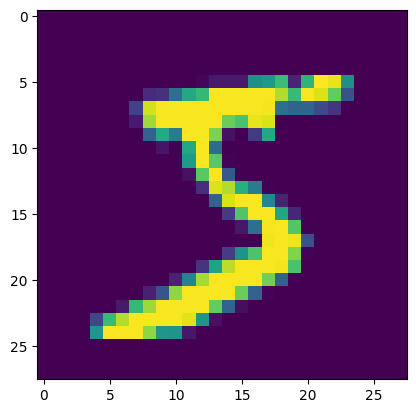

In [5]:
# Affiche la 1ere image des données d'entrainement
print("First image contains a: ", Y_train[0])
plt.imshow(X_train[0].reshape(28, 28))

In [6]:
# on peut facilement récupérer une seule image

x = X_test[0]
y = Y_test[0]

print(x.shape, y.shape, y)

(784,) () 7


## 1.1. Classificateur plus proche voisin

On commence par le classificateur le plus simple : pour prédire le chiffre sur une image, on cherche l'image la "plus proche" (en terme de distance euclidienne) dans les données d'entrainement. et on retourne le chiffre sur cette dernière. Ici, l'entrainement consiste simplement à enregistrer toutes les données d'entrainement.

Pour cela on aura besoin:

1. de savoir calculer la distance euclidienne entre deux vecteurs (i.e. 2 images)
    - vous aurez besoin des fonction `np.sum` de numpy
    - et de l'opérateur de puissance `**`, p. ex. `v ** 2` est le vecteur `v` dont toutes les valeurs ont été mises au carré
    - Note: on peut prendre la distance euclidienne au carré, pas besoin d'appliquer la racine carré
3. chercher l'image dans la proche en terme de cette distance
    - on utilisateur ici la fonction `np.argmin`, dont l'utilisation est illustrée ci-dessous
5. retourner l'étiquette associée à cette image

In [7]:
# examples d'utilisation de la fonction argmin

w = np.random.rand(3)
print(w)
print(w.argmin())
print()

w = np.random.rand(2, 3)
print(w)
print(w.argmin(axis=1))

[0.87495966 0.0630447  0.28717241]
1

[[0.42973082 0.55742625 0.10544527]
 [0.87369751 0.40505091 0.56692942]]
[2 1]


In [12]:
class NNClassifier:
    # dans le constructeur, on copie simplement les données d'entrainement
    def __init__(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        
    # prédit le chiffre sur l'image x
    # en cherchant l'image la plus proche dans X_train
    def predict(self, x):
        assert len(x.shape) == 1
        assert x.shape[0] == self.X_train.shape[1]

        # TODO TODO TODO
        # 1. construire le vecteurs 'distances'
        #    tel que distance[i] soit la distance entre x et self.X_train[i]
        # 2. chercher l'index de l'image la plus proche de x grâce à ce vecteur
        # 3. retourner l'étiquette associé (les étiquettes sont dans le vecteur self.Y_train)
        
        # ....
        distance = np.sum((self.X_train - x) ** 2, axis = 1)
        plus_proche = np.argmin(distance)
        return self.Y_train[plus_proche]
    
    # Calcul la précision du classificateur sur les données X, Y
    def accuracy(self, X, Y):
        assert len(X.shape) == 2
        assert len(Y.shape) == 1
        assert X.shape[1] == self.X_train.shape[1]
        assert X.shape[0] == Y.shape[0]

        # TODO TODO TODO
        # Vous devez bouclez sur les données X,
        # et comparer le résultat obtenu en appelan self.predict
        # avec celui donné dans Y.
        # vous devez ensuite return le % de prédictions correctes

        # ....
        correcte = 0
        for i in range(X.shape[0]):
            if self.predict(X[i]) == Y[i]:
                correcte += 1
        return correcte/X.shape[0]

In [13]:
# construit le classificateur et calcul la précision sur les données de test
# Vous devez obtenir 0.906 :-)

classifier = NNClassifier(X_train, Y_train)
print(classifier.accuracy(X_test, Y_test))

0.906


In [14]:
# on peut aussi calculer la précision sur les données d'entrainement.
# Vous devez obtenir 1.0 :-)

print(classifier.accuracy(X_train[:500], Y_train[:500]))

1.0


## 1.2. Classificateur k plus proches voisins

Maintenant, plutôt que de prédire le chiffre sur l'image la plus proche dans les données d'entrainement, on va chercher les k images les plus proches et prédire le chiffre le plus présent dans celles ci.

Pour cela, on utilisera la fonction kbest définie ci-dessous, qui retourne les indices d'un vecteur qui contient les k plus petites valeus.

In [15]:
def kbest(k, vector):
    assert len(vector.shape) == 1

    return np.argpartition(vector, k)[:k]

In [16]:
v = np.array([0.85011707, 0.81924883, 0.68472504, 0.86888131, 0.45029246])

print(v)
print()
print(kbest(1, v))
print(kbest(3, v))

[0.85011707 0.81924883 0.68472504 0.86888131 0.45029246]

[4]
[4 2 1]


Pour calculer quelle est l'étiquette majoritaire, on peut utiliser un objet de type `Counter`,
donc la documentation est disponible ici: https://docs.python.org/3/library/collections.html#collections.Counter

La fonction ci-dessous retourne la valeur qui apparait le + de fois dans un vecteur d'entiers.

In [17]:
def most_common(vector):
    assert len(vector.shape) == 1
    
    c = collections.Counter(vector)
    return c.most_common(1)[0][0]

In [18]:
v = np.array([1, 1, 3, 4, 4, 3, 1, 4, 2, 3, 3])

print(v)
print(most_common(v))

[1 1 3 4 4 3 1 4 2 3 3]
3


In [19]:
class KNNClassifier:
    # k: nombre de voisins à regarder
    def __init__(self, k, X_train, Y_train):
        self.k = k
        self.X_train = X_train
        self.Y_train = Y_train
        
    def predict(self, x):
        assert len(x.shape) == 1
        assert x.shape[0] == self.X_train.shape[1]

        # TODO TODO TODO
        # comme précédemment, mais il faudrait regarder
        # l'étiquette la + présente parmis le k plus proches images
        
        # ....
        distance = np.sum((self.X_train - x) ** 2, axis = 1)
        pred = most_common(self.Y_train[kbest(k, distance)])
        return pred
    
    def accuracy(self, X, Y):
        assert len(X.shape) == 2
        assert len(Y.shape) == 1
        assert X.shape[1] == self.X_train.shape[1]
        assert X.shape[0] == Y.shape[0]
        
        # TODO TODO TODO
        # comme précédemment
        
        # ....
        correct = 0
        for i in range(X.shape[0]):
            if self.predict(X[i]) == Y[i]:
                correct += 1
        return correct/X.shape[0]

On va maintenant comparer les prédictions sur les données d'entrainement et les données d'évaluation pour plusieurs valeurs de k.

Qu'observez vous ?

In [20]:
for k in range(1, 6):
    classifier = KNNClassifier(k, X_train, Y_train)
    print(k)
    print("Accuracy sur les données d'entrainement:", classifier.accuracy(X_train, Y_train))
    print("Accuracy sur les données d'évaluation:", classifier.accuracy(X_test, Y_test))
    print()

1
Accuracy sur les données d'entrainement: 1.0
Accuracy sur les données d'évaluation: 0.906

2
Accuracy sur les données d'entrainement: 1.0
Accuracy sur les données d'évaluation: 0.906

3
Accuracy sur les données d'entrainement: 0.9778
Accuracy sur les données d'évaluation: 0.924

4
Accuracy sur les données d'entrainement: 0.9782
Accuracy sur les données d'évaluation: 0.918

5
Accuracy sur les données d'entrainement: 0.9664
Accuracy sur les données d'évaluation: 0.912



## 1.3. Classificateur représentants moyens

Dans ce dernier classificateur, nous calculons "l'image moyenne" de chaque classe et utilisons celle ci pour prédire le chiffre sur une nouvelle image.
Cela permet de n'avoir que 10 images à retenir en mêmoire, plutôt que tout le jeu d'entrainement.

Qu'observez vous expérimentalement?

In [21]:
v1 = np.array([1., 0., 0.])
v2 = np.array([1., 10., 10.])
v3 = np.array([1., 5., 10.])

# deux solutions parmis tant d'autres pour calculer la moyenne de v1, v2 et v3

print((v1+v2+v3) / 3)
print()

v = v1
v += v2
v += v3
print(v / 3)

[1.         5.         6.66666667]

[1.         5.         6.66666667]


In [28]:
class MeanClassifier:
    def __init__(self, n_classes, X_train, Y_train):
        # matrice qui contiendra le représentant de chaque classe,
        # c'est à dire que self.mean[i] doit être le vecteur moyen de toutes les images étiquetées i dans X_train
        self.mean = np.zeros((n_classes, X_train.shape[1]))
        
        # TODO TODO TODO
        # Calculer le représentant de chaque classe,
        # c'est-à-dire compléter la matric self.mean
        
        # ....
        for c in range(n_classes):
            vecs = X_train[Y_train == c]
            self.mean[c] = np.mean(vecs, axis = 0)
        
    def predict(self, x):
        assert len(x.shape) == 1

        # TODO TODO TODO
        # chercher le représentant le plus proche et retourner l'étiquette correspondante
        
        # ....
        distance = np.sum((self.mean - x) ** 2, axis = 1)
        plus_proche = np.argmin(distance)
        return plus_proche
    
    def accuracy(self, X, Y):
        assert len(X.shape) == 2
        assert len(Y.shape) == 1
        assert X.shape[1] == self.mean.shape[1]
        assert X.shape[0] == Y.shape[0]
        
        # TODO TODO TODO
        # Comme précédemment
        
        # ....
        correct = 0
        for i in range(X.shape[0]):
            if self.predict(X[i]) == Y[i]:
                correct += 1
        return correct/X.shape[0]

In [29]:
classifier = MeanClassifier(10, X_train, Y_train)
print("Accuracy sur les données d'entrainement:", classifier.accuracy(X_train, Y_train))
print("Accuracy sur les données d'évaluation:", classifier.accuracy(X_test, Y_test))

Accuracy sur les données d'entrainement: 0.8132
Accuracy sur les données d'évaluation: 0.778


# 2. Régression avec un modèle k plus proches voisins

Dans cette dernière partie, nous nous intéressons à un modèle de prédiction.
Dans ce cas, lorsque vous récupérez les k plus proches voisins, la prédiction est la moyenne de leur étiquette (plutôt que l'étiquette majoritaire comme pour la classification).

Nous utilisons pour ça un jeu de donné dont les entrées sont des vitesses d'un véhicule et la sortie la distance nécessaire pour le freinage.

In [30]:
# lecture des données
def read_speed_and_dist(path):
    x = list()
    y = list()
    with open(path) as instream:
        next(instream)
        for line in instream:
            line = line.strip()
            if len(line) > 0:
                line = line.split(",")
                x.append(float(line[1]))
                y.append(float(line[2]))
    ret_X = np.array(x).reshape(len(x), 1)
    ret_y = np.array(y)
    
    return ret_X, ret_y

X, y = read_speed_and_dist("Speed_and_Stopping_Distances_of_Cars_357_90.csv")
X.shape, y.shape

((50, 1), (50,))

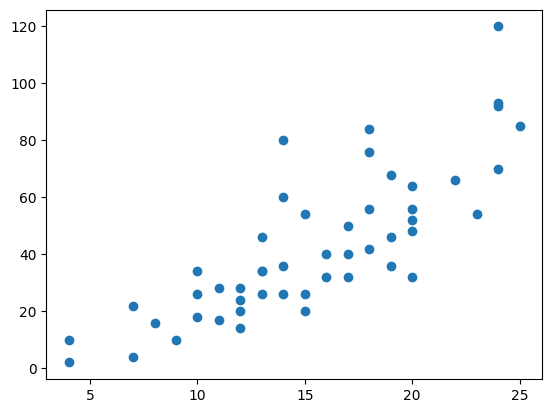

In [31]:
# on peut afficher les données.
# les entrées sont en dimension 1 (axe horizontal),
# et les sorties sont données sur l'axe vertical.
plt.scatter(X[:, 0], y)

In [32]:
class KNNRegression:
    # k: nombre de voisins à regarder
    def __init__(self, k, X_train, Y_train):
        self.k = k
        self.X_train = X_train
        self.Y_train = Y_train
        
    def predict(self, x):
        assert len(x.shape) == 1
        assert x.shape[0] == self.X_train.shape[1]

        # TODO TODO TODO
        
        # ....
        distance = np.sum((self.X_train - x) ** 2, axis = 1)
        plus_proche = kbest(k, distance)
        return np.mean(self.Y_train[plus_proche])
    

On affiche sur un graphe la comparaison entre les données d'entrainement (sous forme de points)
et le prédiction du modèle en fonction de la vitesse.

Qu'observez vous ? Obtendrais-t-on le même genre de prédiction avec un modèle linéaire ?

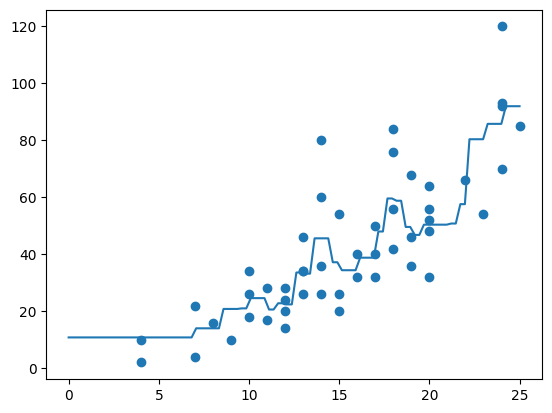

In [33]:
model = KNNRegression(2, X, y)
xs = np.linspace(0, 25, 100)
y_pred = [model.predict(np.array([x])) for x in xs]

plt.scatter(X[:, 0], y)
plt.plot(xs, y_pred)
